<a href="https://colab.research.google.com/github/DidierAgamez/EduFinance_Simulator/blob/main/Proyecto_MR_EDUFinance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- Portada + Descripción general -->
<details open>
<summary><h2 style="display:inline; font-size:64px; color:#2b6cb0">📘 EduFinance - Simulator</h2></summary>

<p style="margin:0;color:#555">
Herramienta académica y de simulación financiera: desde el EDA hasta modelos, dashboard y conclusiones.
</p>

---

### 🎯 Propósito
Construir una herramienta **académica y reproducible** que permita:
- Obtener **series de tiempo reales** (ETFs, acciones y criptomonedas).
- **Normalizar calendarios** para comparabilidad entre activos.
- Realizar **análisis exploratorio (EDA)** con estadísticas, correlaciones y visualizaciones.
- (Fases siguientes) Entrenar y comparar **modelos clásicos y redes neuronales**, y presentar resultados en un **dashboard** interactivo, con **intervalos de confianza de hasta 95%** y lenguaje de **escenarios probabilísticos**.

### 🧪 Alcance de esta versión del notebook
- **Conjunto piloto:** VOO, QQQ, EUNL.DE, XAR, TSLA, V, BTC-USD, XRP-USD.  
- **Frecuencia:** diaria.  
- **Fecha de corte fija (reproducibilidad):** **2025-09-05**.  
- **Moneda:** USD (salvo EUNL.DE en EUR).  
- **Fuente:** Yahoo Finance vía `yfinance` (precios **ajustados**: dividendos/splits).

> ℹ️ Este notebook es el **contenedor principal del proyecto** y crecerá por secciones:  
> 1) Preparación del entorno · 2) Descarga de datos · 3) Normalización · 4) EDA ·  
> 5) Modelos (ARIMA/GARCH/Prophet/LSTM) · 6) Dashboard · 7) Resultados y conclusiones.

### 🛡️ Aviso académico
Este material es **pedagógico**. Los resultados son escenarios **probabilísticos** derivados de datos y modelos; **no constituyen asesoría financiera**.

### 🔁 Reproducibilidad
- Fechas y dependencias documentadas en el propio notebook.
- Descarga **programática** de datos desde `yfinance`.
- Normalización a **días hábiles (L–V)** para comparabilidad entre clases de activos.

</details>



<!-- Preparación del entorno -->
<details open>
<summary><h1 style="display:inline; font-size:36px; color:#2b6cb0">🔧 1. Preparación del entorno</h1></summary>

En esta sección configuramos el entorno de trabajo en **Google Colab** para asegurar que el
notebook sea **reproducible en cualquier máquina**.  

### Objetivos
- Verificar la versión de Python instalada.  
- Instalar y/o actualizar las librerías necesarias:  
  - **pandas, numpy** → manipulación de datos.  
  - **matplotlib, seaborn, plotly** → visualización.  
  - **yfinance** → descarga de datos de acciones y ETFs.  
  - **pycoingecko** → (opcional, criptos si fuese necesario).  
  - **pyyaml** → guardar metadatos (dataset cards).  

### Notas importantes
- En Colab algunas librerías ya vienen instaladas, pero las forzamos para evitar diferencias de versión.  
- El comando `subprocess.run([...])` permite instalar paquetes de forma programática.  
- Esta sección **solo instala y configura dependencias**, no descarga aún los datos.  

</details>


In [158]:
"""
Preparación del entorno

Objetivo:
- Instalar/actualizar librerías que usaremos en TODO el proyecto (EDA, modelos, dashboard).
- Hacemos una sola instalación para evitar inconsistencias posteriores.

Notas:
- Usamos 'sys.executable -m pip' por robustez en Colab.
- '--quiet' reduce el ruido en la salida.
"""
import sys, subprocess

print(f"Python: {sys.version}")

# Paquetes necesarios (con una línea explicativa por paquete)
pkgs = [
    "pandas",     # Tablas y manipulación de datos (DataFrames)
    "numpy",      # Cálculo numérico y arreglos n-dimensionales
    "matplotlib", # Gráficos base en Python (estático)
    "seaborn",    # Estilos y funciones estadísticas sobre matplotlib
    "plotly",     # Gráficos interactivos (para el dashboard y exploración)
    "yfinance",   # Descarga de precios históricos (ETFs/acciones/criptos) desde Yahoo Finance
    "pyyaml",     # Lectura/escritura de archivos YAML (metadatos/dataset cards)

]

# Instalación/actualización
subprocess.run(
    [sys.executable, "-m", "pip", "install", "--quiet", "--upgrade", *pkgs],
    check=False
)
print("✅ Dependencias instaladas/actualizadas.")



Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
✅ Dependencias instaladas/actualizadas.


In [159]:
"""
Imports y estilo global de visualización
- Importamos solo lo necesario.
- Definimos un estilo global coherente para todas las figuras:
  • Tipografía legible
  • Grids suaves
  • Tamaños y márgenes consistentes
  • Tema claro (fácil de leer en clase y en GitHub)
"""
import pandas as pd        # Tablas y manipulación de datos
import numpy as np         # Cálculo numérico y arreglos n-dimensionales

import matplotlib.pyplot as plt  # Visualización base
import seaborn as sns            # Visualizaciones estadísticas sobre matplotlib
import plotly.io as pio          # Gráficos interactivos

from IPython.display import display_html
import yfinance as yf       # Descarga de datos financieros (ETFs, acciones, criptos)
import yaml                 # Lectura/escritura de archivos YAML (metadatos/dataset cards)

from functools import lru_cache  # Memoización de funciones (evita repetir consultas costosas)
from typing import Tuple, Dict # Permite el uso de anotaciones de tipo para Tuple y Dict
import datetime # Módulo para trabajar con fechas y horas.

def apply_global_style():
    """
    Aplica un estilo visual consistente a matplotlib, seaborn y plotly.
    Llama a esta función una vez al inicio del notebook.
    """
    # --- seaborn (con matplotlib debajo) ---
    sns.set_theme(
        context="notebook",   # tamaño de textos pensado para notebooks
        style="whitegrid",    # fondo claro con grilla suave
        palette="deep"        # paleta por defecto sobria
    )
    # Ajustes base de matplotlib
    plt.rcParams.update({
        "figure.figsize": (10, 4),     # tamaño estándar de figuras
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": "-",
        "legend.frameon": False,
        "savefig.dpi": 300,            # exportar PNG nítidos
        "savefig.bbox": "tight"
    })

    # --- plotly ---
    # Plantilla clara y legible (se puede cambiar a 'plotly_dark' si hiciera falta)
    pio.templates.default = "plotly_white"

# Aplicamos el estilo global al cargar el notebook
apply_global_style()
print("🎨 Estilo global aplicado (matplotlib, seaborn y plotly).")


🎨 Estilo global aplicado (matplotlib, seaborn y plotly).


In [160]:
"""
📌 Verificación de versiones
- Registrar versiones ayuda a replicar resultados (útil para README/ informe).
"""
import importlib

def version_of(pkg_name: str) -> str:
    try:
        m = importlib.import_module(pkg_name)
        return getattr(m, "__version__", "N/D")
    except Exception:
        return "No importado"

versions = {
    "python": sys.version.split()[0],
    "pandas": version_of("pandas"),
    "numpy": version_of("numpy"),
    "matplotlib": version_of("matplotlib"),
    "seaborn": version_of("seaborn"),
    "plotly": version_of("plotly"),
    "yfinance": version_of("yfinance"),
    "yaml (PyYAML)": version_of("yaml"),
}
versions


{'python': '3.12.11',
 'pandas': '2.3.2',
 'numpy': '2.0.2',
 'matplotlib': '3.10.0',
 'seaborn': '0.13.2',
 'plotly': '6.3.0',
 'yfinance': '0.2.66',
 'yaml (PyYAML)': '6.0.2'}

<!-- Obtención de datos y EDA inicial -->
<details open>
<summary><h1 style="display:inline; font-size:36px; color:#2b6cb0">📊 2. Obtención de datos y análisis exploratorio inicial</h1></summary>

En esta sección iniciamos el **pipeline de datos** del proyecto.  
El objetivo es construir un dataset homogéneo y confiable que sirva de base para los modelos posteriores.

---

<h2 style="font-size:36px; color:#2b6cb0">🎯 Objetivos de esta fase</h2>  

1. **Descargar series de tiempo** en frecuencia diaria para el conjunto piloto de activos:
   - ETFs → VOO, QQQ, EUNL.DE, XAR  
   - Acciones → TSLA, V  
   - Criptos → BTC-USD, XRP-USD  

2. **Variables a recolectar:**
   - `date` → fecha de negociación.  
   - `ticker` → identificador único del activo.  
   - `asset_class` → tipo de activo (ETF/acción/cripto).  
   - `close` → precio de cierre ajustado (incluye dividendos y splits).
   - `currency` → moneda en la que se encuentra el activo.

3. **Rango temporal:**  
   - Inicio: **2015-01-02**  
   - Corte fijo: **2025-09-05**  

4. **Construir un DataFrame “tidy”** con los activos alineados por fecha.

---

<h2 style="font-size:36px; color:#2b6cb0">📦 Conjunto piloto de activos</h2>  

Para el primer análisis exploratorio de datos vamos a definir un **conjunto de datos piloto** de activos, los cuales nos servirán como base para posteriormente escalar el proyecto.  

Este conjunto piloto está conformado por **3 tipos de activos**: **ETFs, acciones individuales y criptomonedas**.  

A continuación se presenta una breve descripción de cada uno, con sus características y la justificación de su inclusión:  

---

### **ETF (Exchange Traded Fund)**  
Un **ETF** es un fondo cotizado en bolsa que agrupa diversos activos financieros (acciones, bonos o materias primas). Se puede comprar y vender como si fuera una acción, y en general replica un índice.  

#### ETFs seleccionados:
- **VOO – Vanguard S&P 500 ETF**  
  *Replica el S&P 500 (500 grandes compañías de EE. UU.)*  
  - **¿Por qué escogerlo?**: Nos da una base sobre el mercado estadounidense y su comportamiento.  

- **QQQ – Invesco QQQ Trust (Nasdaq-100)**  
  *Replica el Nasdaq-100 (100 grandes compañías no financieras del Nasdaq)*  
  - **¿Por qué escogerlo?**: Permite analizar el comportamiento del sector tecnológico y compararlo frente a índices más diversificados.  

- **EUNL – iShares Core MSCI World UCITS ETF (Acc)**  
  *Replica el MSCI World (mercados desarrollados, acumulativo)*  
  - **¿Por qué escogerlo?**: Aporta cobertura global y reinvierte dividendos, lo que permite analizar diversificación internacional.  

- **XAR – SPDR S&P Aerospace & Defense ETF**  
  *Replica el S&P Aerospace & Defense Select Industry Index, con ponderación equitativa entre compañías*  
  - **¿Por qué escogerlo?**: Da exposición diversificada al sector defensa, considerado más estable, ideal para contrastar con ETFs amplios o tecnológicos.  

---

### **Acciones**  
Una acción representa una **porción del capital** de una empresa.  

#### Acciones seleccionadas:
- **TSLA – Tesla, Inc.**  
  *Vehículos eléctricos y energías renovables, empresa de alto crecimiento.*  
  - **¿Por qué escogerlo?**: Alta volatilidad y fuerte correlación con sectores de innovación. Representa un perfil “growth”.  

- **V – Visa Inc.**  
  *Red global de pagos electrónicos.*  
  - **¿Por qué escogerlo?**: Menor volatilidad, perfil más estable. Representa un sector defensivo y ligado al consumo global.  

---

### **Criptomonedas**  
Las **criptomonedas** son dinero digital descentralizado, asegurado mediante tecnología **blockchain**. No dependen de bancos ni gobiernos, funcionan de manera **24/7**.  

#### Criptos seleccionadas:
- **BTC – Bitcoin**  
  *Primera criptomoneda (2009), considerada reserva digital de valor.*  
  - **¿Por qué escogerlo?**: Alta volatilidad, opera sin restricciones horarias, referente principal del ecosistema cripto.  

- **XRP – XRP Ledger**  
  *Cripto enfocada en pagos rápidos y de bajo costo.*  
  - **¿Por qué escogerlo?**: Aporta diversidad frente a BTC, ya que está enfocada en utilidad transaccional más que en reserva de valor.  

---

<h2 style="font-size:36px; color:#2b6cb0">🧪 EDA inicial (antes de limpieza)</h2>  

Con los datos descargados, realizaremos un **primer análisis exploratorio** para:  
- Revisar cuántos datos válidos tenemos por activo.  
- Detectar valores nulos (cierres vacíos, feriados, fines de semana en criptos, etc.).  
- Calcular estadísticas básicas por activo: media, desviación estándar.  
- Visualizar correlaciones entre activos mediante un **heatmap**.  

Este paso **no sustituye la limpieza**, sino que nos ayuda a entender la calidad y consistencia del dataset crudo.

---

<h2 style="font-size:36px; color:#2b6cb0">🔁 Flujo del proceso</h2>  

1. Descarga → datos crudos diarios desde **Yahoo Finance** (`yfinance`).  
2. EDA previo → estadísticos y gráficas para detectar inconsistencias.  
3. Normalización y limpieza (en la siguiente fase).  

</details>



In [161]:
"""
Constantes del proyecto (fase EDA)
- Tickers del conjunto piloto con comentario corto por cada uno.
- Fechas fijas para reproducibilidad (no cambiar sin dejar constancia en el README).
"""

TICKERS_YF = [
    "VOO",      # Vanguard S&P 500 ETF (EE. UU., 500 grandes empresas)
    "QQQ",      # Invesco Nasdaq-100 ETF (tecnología/crecimiento)
    "EUNL.DE",  # iShares MSCI World (Xetra, EUR; exposición global desarrollados)
    "XAR",      # SPDR Aerospace & Defense ETF (sector defensa)
    "TSLA",     # Tesla Inc. (vehículos eléctricos / energía)
    "V",        # Visa Inc. (pagos electrónicos)
    "BTC-USD",  # Bitcoin en USD (cripto 24/7)
    "XRP-USD"   # XRP en USD (cripto 24/7)
]

START_DATE = "2015-01-02"  # fecha de inicio fija acordada
END_DATE   = "2025-09-05"  # fecha de corte fija acordada

print("✅ Constantes definidas.")
print("Tickers:", TICKERS_YF)
print("Rango:", START_DATE, "→", END_DATE)


✅ Constantes definidas.
Tickers: ['VOO', 'QQQ', 'EUNL.DE', 'XAR', 'TSLA', 'V', 'BTC-USD', 'XRP-USD']
Rango: 2015-01-02 → 2025-09-05


In [162]:
@lru_cache(maxsize=None)
def _get_meta_from_yf(tk: str) -> dict:
    """
    Función: _get_meta_from_yf
    -------------------------------------
    Obtiene metadatos básicos de un ticker financiero desde Yahoo Finance.

    Propósito
    --------
    - Determinar de manera automática:
        • 'asset_class' → Clase de activo (ej.: Stock, ETF, Crypto, etc.)
        • 'currency'    → Moneda principal de cotización (ej.: USD, EUR).
    - Utilizar primero métodos rápidos (fast_info) y, en caso de no encontrar
      la información, usar métodos más completos (info).
    - Proporcionar **reglas de respaldo (heurísticas)** para casos en los que
      Yahoo Finance no devuelve la información esperada.

    Parámetros
    ----------
    tk : str
        Símbolo del activo en Yahoo Finance.
        Ejemplos:
        - "VOO"       → Vanguard S&P 500 ETF
        - "TSLA"      → Tesla Inc.
        - "BTC-USD"   → Bitcoin en USD
        - "EUNL.DE"   → iShares MSCI World en Xetra (EUR)

    Retorna
    -------
    dict
        Diccionario con dos claves:
        {
            "asset_class": str, #clase del activo (Stock, ETF, Crypto, Unknown...)
            "currency": str     #moneda principal de negociación (USD, EUR, ...)
        }

    Detalles de implementación
    --------------------------
    1. Intento inicial con `fast_info`
       - Es un acceso rápido proporcionado por `yfinance`.
       - Extraemos `currency` y `quoteType` si están disponibles.
       - Mapeamos `quoteType` a una clase de activo conocida.

    2. Intento secundario con `info`
       - Más costoso en tiempo y puede fallar.
       - Usado solo si no se obtuvieron valores de `fast_info`.

    3. Reglas de respaldo (heurísticas)
       - Si el ticker tiene formato `XXX-USD`, `XXX-EUR`, etc. → se asume "Crypto".
       - Si termina en `.DE` (mercado Xetra, Alemania) → se asigna "EUR" como moneda.
       - Otros patrones podrían añadirse según se amplíe el proyecto.

    4. Valores por defecto
       - Si no se logra inferir el tipo de activo → "Unknown".
       - Si no se logra inferir la moneda → "USD".

    Decorador
    ---------
    @lru_cache(maxsize=None)
    - Memoriza resultados en caché.
    - Evita consultas repetidas a Yahoo Finance para el mismo ticker,
      mejorando la eficiencia.

    """
    #Se instancia el objeto tickerde yfinance para el simbolo solicitado
    t = yf.Ticker(tk)

    #Inicializamos las variables
    asset_class = None
    currency    = None

    # 1) Hacemos un intento rapido cons fast_info
    try:
        fi = getattr(t, "fast_info", None) or {}
        if hasattr(fi, "__dict__"):
            fi = fi.__dict__
        #Moneda de cotizacion
        currency    = fi.get("currency", None)
        #Tipo de instrumento (si esta disponible): mapeamos la clase
        quote_type  = fi.get("quoteType", None)
        if quote_type:
          asset_class = {
              "EQUITY": "Stock",
              "ETF": "ETF",
              "MUTUAL_FUND": "Mutual Fund",
              "CRYPTOCURRENCY": "Crypto",
              "INDEX": "Index",
          }.get(str(quote_type).upper(), None)
    except Exception: pass

    # 2) Intento completo con info (más costoso y propenso a fallos)
    #  - Sólo se consulta si aún faltan datos (asset_class o currency).
    if asset_class is None or currency is None:
        try:
            info = t.info  # Puede tardar / lanzar excepciones según el ticker
            if currency is None:
                currency = info.get("currency", None)
            if asset_class is None:
                qt = info.get("quoteType", None)
                if qt:
                    asset_class = {
                        "EQUITY": "Stock",
                        "ETF": "ETF",
                        "CRYPTOCURRENCY": "Crypto",
                        "MUTUALFUND": "Fund",
                        "INDEX": "Index",
                    }.get(str(qt).upper(), None)
        except Exception: pass


    # 3) Heurísticas de respaldo
    #  - Si no pudimos inferir la clase/moneda por API, deducimos por patrón.

    if asset_class is None:
        # Patrones típicos de tickers cripto: 'XXX-USD', 'XXX-EUR', 'XXX-USDT', etc.
        if "-" in tk and tk.split("-")[-1] in {"USD", "EUR", "USDT", "BTC", "ETH"}:
            asset_class = "Crypto"

    if currency is None:
        # Si el ticker contiene '-', el segmento final suele ser la divisa
        # (p. ej., 'BTC-USD' → 'USD').
        if "-" in tk:
            maybe_ccy = tk.split("-")[-1]
            # Códigos ISO típicos de 3 letras (o 4 en el caso de USDT)
            if len(maybe_ccy) in (3, 4):
                currency = maybe_ccy

        # Sufijo de bolsa alemana (.DE) → eurístico a EUR (Xetra)
        if currency is None and tk.endswith(".DE"):
            currency = "EUR"

    # 4) Valores por defecto si no se pudo inferir
    asset_class = asset_class or "Unknown"
    currency = currency or "USD"

    # Retornamos los metadatos consolidados
    return {"asset_class": asset_class, "currency": currency}


In [163]:
def download_yf(tickers, start, end) -> pd.DataFrame:
    """
    Descarga diaria (precios AJUSTADOS) desde Yahoo Finance para múltiples tickers,
    devolviendo un DataFrame en **formato tidy** listo para EDA y limpieza.

    Propósito
    ---------
    - Realizar una única consulta a Yahoo Finance para todos los tickers.
    - Traer precios **ajustados** (incluyen dividendos y splits) para evitar
      saltos artificiales en la serie.
    - Normalizar la salida a un esquema uniforme con columnas:
      ['date', 'ticker', 'asset_class', 'close', 'currency'].

    Parámetros
    ----------
    tickers : list[str]
        Lista de símbolos de Yahoo Finance (ej.: ['VOO', 'QQQ', 'TSLA', 'BTC-USD']).
    start : str | datetime.date | datetime.datetime
        Fecha de inicio del periodo (incluyente si hay datos). Ej.: '2015-01-01'.
    end : str | datetime.date | datetime.datetime
        Fecha de fin/corte (incluyente si hay datos). Ej.: '2025-09-05'.

    Retorna
    -------
    pd.DataFrame
        DataFrame **tidy** con una fila por (fecha, ticker) y columnas:
        - date        : fecha (naive, tipo date)
        - ticker      : símbolo del activo
        - asset_class : clase inferida automáticamente (Stock, ETF, Crypto, ...)
        - close       : precio de cierre **ajustado**
        - currency    : divisa (USD, EUR, ...)

    Notas
    -----
    - Las criptomonedas operan 24/7, por lo que suelen traer más fechas
      que acciones/ETFs. La normalización de calendarios se hace después.
    - No se incluye 'volume' en esta fase (nos enfocamos en precios).
    - Si un ticker no trae columna de cierre ('Close' o 'Adj Close'), se omite
      con aviso (caso poco frecuente).

    Ejemplos
    --------
    >>> df = download_yf(['VOO', 'BTC-USD'], '2020-01-01', '2020-12-31')
    >>> df.head()
           date   ticker asset_class    close currency
    0  2020-01-02     VOO         ETF  293.540      USD
    1  2020-01-03     VOO         ETF  291.140      USD
    2  2020-01-06     VOO         ETF  293.950      USD
    3  2020-01-07     VOO         ETF  293.520      USD
    4  2020-01-08     VOO         ETF  295.320      USD
    """

    # 1) Descarga en panel (MultiIndex por ticker)
    raw = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        interval="1d",     # Descarga los precios por dia
        auto_adjust=True,  # Precios ajustados (dividendos/splits)
        group_by="ticker", # Las columnas vienen agrupadas por cada símbolo.
        threads=True
    )

    frames = []  # Aquí acumularemos cada sub-DF ya normalizado

    # 2) Iteramos por cada ticker para normalizar a formato 'tidy'
    for tk in tickers:
        # Si hay múltiples tickers, 'raw' es dict-like y raw[tk] existe.
        # Si sólo hay uno, 'raw' ya es el DataFrame del ticker.
        try:
            df_tk = raw[tk].copy()
        except Exception:
            df_tk = raw.copy()

        # Asegurarnos de capturar la columna de cierre ajustado:
        # yfinance puede llamarla 'Adj Close' o 'Close' según el caso.
        cols = [c for c in df_tk.columns if c.lower() in ("close", "adj close")]
        if not cols:
            print(f"No se encontró columna de cierre para {tk}. Ticker omitido.")
            continue

        # Renombramos a 'close' para unificar nomenclatura
        df_tk = df_tk[cols].rename(columns={"Adj Close": "close", "Close": "close"})

        # Pasamos el índice de fecha a columna y estandarizamos el nombre 'date'
        df_tk = df_tk.reset_index().rename(columns={"Date": "date"})

        # Inferimos metadatos automáticos (clase y moneda) con función cacheada
        meta = _get_meta_from_yf(tk)

        # Inyectamos metadatos y reordenamos columnas
        df_tk["ticker"] = tk
        df_tk["asset_class"] = meta["asset_class"]
        df_tk["currency"] = meta["currency"]
        df_tk = df_tk[["date", "ticker", "asset_class", "close", "currency"]]

        frames.append(df_tk)


    #3) Unión de todos los tickers + tipado de fecha + orden y deduplicado
    out = pd.concat(frames, ignore_index=True)
    out["date"] = pd.to_datetime(out["date"]).dt.date  # trabajamos con 'date' naive
    out = (
        out.sort_values(["ticker", "date"])
           .drop_duplicates()
           .reset_index(drop=True)
    )

    # 4) Sanity check básico para avisar de posibles problemas de descarga
    if out.empty:
        raise RuntimeError("La descarga produjo un DataFrame vacío. Verifica tickers/fechas.")
    # Aviso suave si hubiera demasiados nulos (conexión inestable o símbolo raro)
    null_ratio = out["close"].isna().mean()
    if null_ratio > 0.50:
        print("Más del 50% de 'close' es NaN; revisa conexión o símbolos.")

    return out
market_df = download_yf(TICKERS_YF, START_DATE, END_DATE)

[*********************100%***********************]  8 of 8 completed


In [164]:
"""
Sanity check: Cobertura temporal por ticker

El objetivo de este bloque es verificar que la descarga de datos
desde Yahoo Finance fue correcta para cada activo.

1. Agrupamos por 'ticker'.
2. Calculamos:
  - first_date: primera fecha disponible en la serie.
  - last_date : última fecha disponible.
  - n_rows    : cantidad total de observaciones (filas).
  - n_missing : cantidad de valores nulos en 'close'.
3. Ordenamos los resultados por ticker para facilitar la inspección.

Este chequeo es importante porque:
  - Nos ayuda a identificar si algún activo tiene un rango temporal
    mucho más corto que el resto (ej. XRP con datos recientes).
  - Detecta gaps grandes o descargas vacías.
  - Nos da un panorama rápido de la consistencia antes de pasar
  a la normalización de fechas.

"""

checks = (
    market_df
    .groupby("ticker")
    .agg(
        first_date=("date", "min"),   # primera fecha disponible
        last_date=("date", "max"),    # última fecha disponible
        n_rows=("date", "count"), # cantidad de observaciones
        n_missing = ("close", lambda s: s.isna().sum()), # nulos en 'close'
        asset_class = ("asset_class", "first"), # clase del activo
        currency = ("currency", "first")
    )
    .sort_index()
)

checks


,first_date,last_date,n_rows,n_missing,asset_class,currency
ticker,,,,,,
BTC-USD,2015-01-02,2025-09-04,3899,0,Crypto,USD
EUNL.DE,2015-01-02,2025-09-04,3899,1184,ETF,EUR
QQQ,2015-01-02,2025-09-04,3899,1215,ETF,USD
TSLA,2015-01-02,2025-09-04,3899,1215,Stock,USD
V,2015-01-02,2025-09-04,3899,1215,Stock,USD
VOO,2015-01-02,2025-09-04,3899,1215,ETF,USD
XAR,2015-01-02,2025-09-04,3899,1215,ETF,USD
XRP-USD,2015-01-02,2025-09-04,3899,1042,Crypto,USD


In [165]:
"""
Agrupación en base al ticker (para visualización)
"""
for ticker, group in market_df.groupby('ticker'):
    print(f"Ticker: {ticker}")
    print(group.head(10))
    print("\n" + "="*50 + "\n") # Separador para una mejor visualización

Ticker: BTC-USD
Price        date   ticker asset_class       close currency
0      2015-01-02  BTC-USD      Crypto  315.032013      USD
1      2015-01-03  BTC-USD      Crypto  281.082001      USD
2      2015-01-04  BTC-USD      Crypto  264.195007      USD
3      2015-01-05  BTC-USD      Crypto  274.473999      USD
4      2015-01-06  BTC-USD      Crypto  286.188995      USD
5      2015-01-07  BTC-USD      Crypto  294.337006      USD
6      2015-01-08  BTC-USD      Crypto  283.348999      USD
7      2015-01-09  BTC-USD      Crypto  290.407990      USD
8      2015-01-10  BTC-USD      Crypto  274.795990      USD
9      2015-01-11  BTC-USD      Crypto  265.660004      USD


Ticker: EUNL.DE
Price        date   ticker asset_class      close currency
3899   2015-01-02  EUNL.DE         ETF  34.259998      EUR
3900   2015-01-03  EUNL.DE         ETF        NaN      EUR
3901   2015-01-04  EUNL.DE         ETF        NaN      EUR
3902   2015-01-05  EUNL.DE         ETF  33.939999      EUR
3903   2015

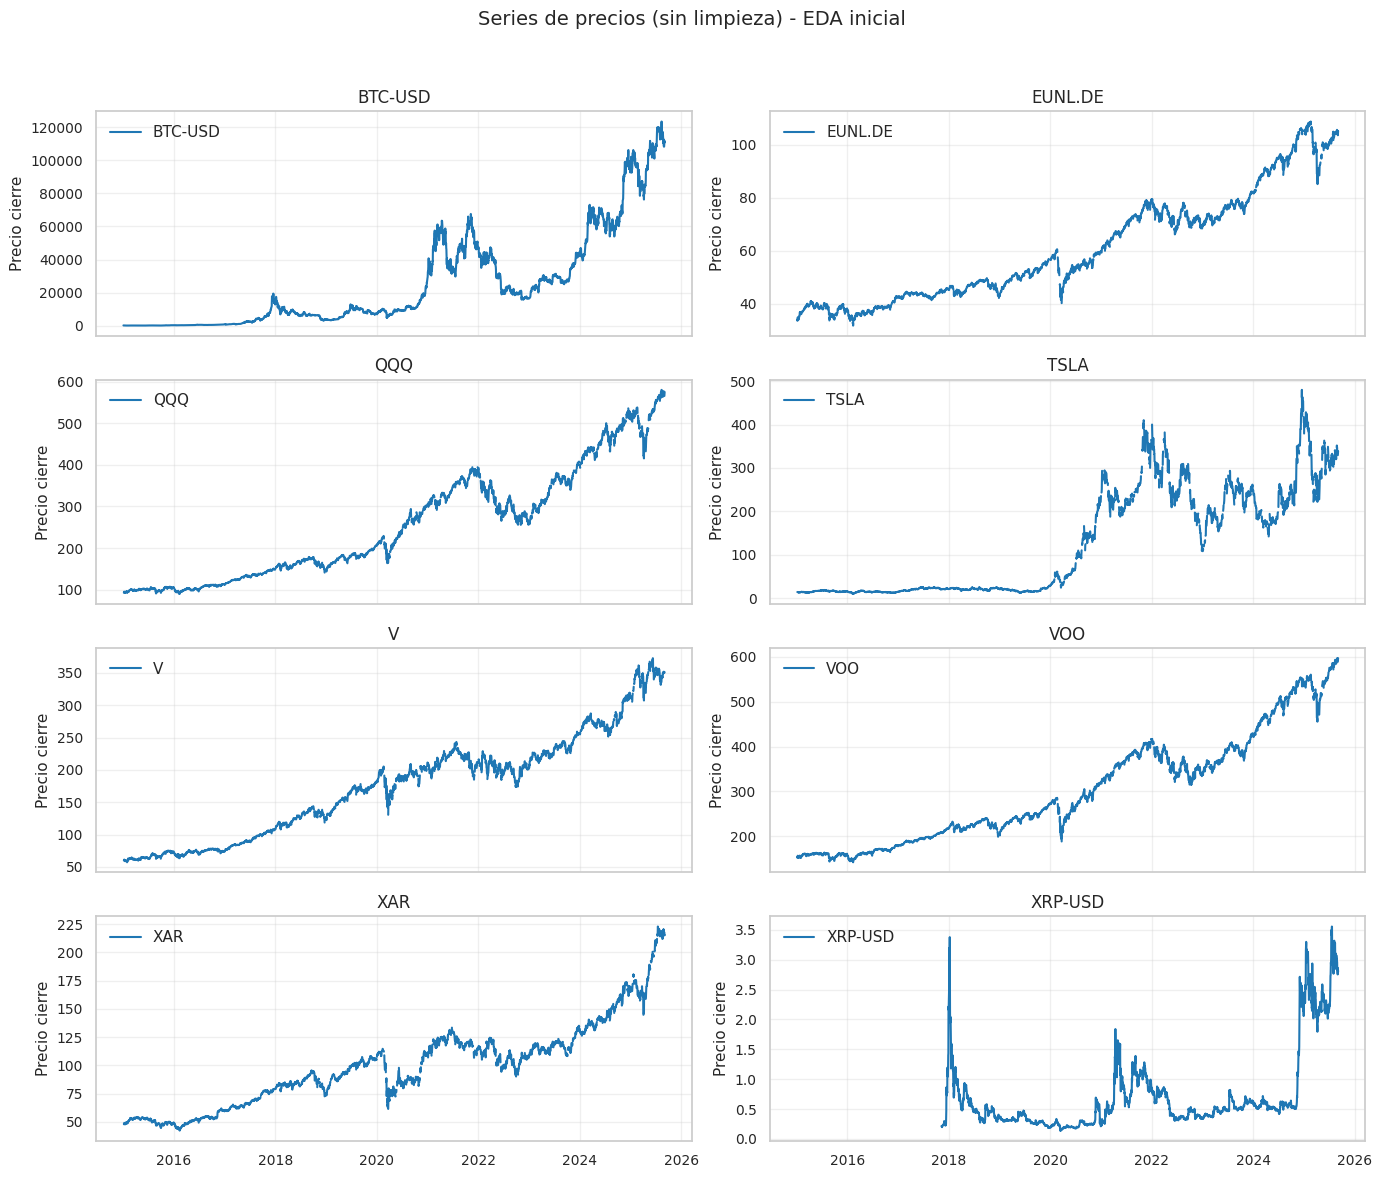

In [166]:
def plot_subplots(df: pd.DataFrame):
    """
    Genera subplots de series de precios (sin limpieza previa) para cada ticker
    contenido en un DataFrame en formato tidy.

    Propósito
    ---------
    - Visualizar de forma rápida la evolución de precios de cierre ajustados
      para todos los tickers disponibles en el dataset.
    - Explorar tendencias, volatilidad y posibles anomalías antes de la fase
      de limpieza y normalización.
    - Ofrecer una visión comparativa mediante subplots ordenados en cuadrícula.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame en formato tidy con las columnas mínimas:
        - 'date'   : fecha (datetime.date)
        - 'ticker' : símbolo del activo
        - 'close'  : precio de cierre ajustado

    Notas
    -----
    - El número de filas en la cuadrícula de subplots se calcula dinámicamente
      en función del número total de tickers.
    - Se crean siempre 2 columnas de gráficos para mejor legibilidad.
    - Si el número de tickers es impar, los ejes sobrantes se eliminan.
    - Cada subplot incluye título con el ticker, leyenda y grilla ligera.
    - El gráfico general incluye un título común a todos los subplots.

    Ejemplos
    --------
    >>> plot_subplots(market_df)
    # Devuelve una cuadrícula de gráficos con la serie de precios por ticker.
    """
    tickers = df["ticker"].unique()
    n = len(tickers)

    # Definimos tamaño de figura (filas dinámicas, 2 columnas)
    ncols = 2
    nrows = (n + 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(14, 3 * nrows), sharex=True)

    # Aplanamos ejes para iterar fácilmente
    axes = axes.flatten()

    # Iteramos sobre cada ticker y generamos la serie
    for i, tk in enumerate(tickers):
        subset = df[df["ticker"] == tk]
        axes[i].plot(subset["date"], subset["close"], label=tk, color="tab:blue")
        axes[i].set_title(f"{tk}", fontsize=12)
        axes[i].set_ylabel("Precio cierre")
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()

    # Quitamos ejes sobrantes si el número de tickers es impar
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Título general y ajuste de espaciado
    plt.suptitle("Series de precios (sin limpieza) - EDA inicial", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_subplots(market_df)


<details open>
<summary><h1 style="display:inline; font-size:36px; color:#d69e2e">🧹 3. Limpieza y normalización de los datos</h1></summary>

En esta fase transformaremos el dataset crudo descargado en un conjunto **homogéneo y confiable** para análisis y modelado.  
El objetivo es garantizar que todos los activos estén alineados en el mismo calendario y con valores consistentes.

---

##🎯 Objetivos de la limpieza

1. **Unificar el punto de inicio**:  
   - Detectar la primera fecha válida de cada ticker.  
   - Escoger la **fecha más reciente** como inicio común (ej.: XRP suele ser la más tardía).  

2. **Normalizar el calendario de negociación**:  
   - Usar un calendario de **días hábiles (lunes–viernes)** como referencia.  
   - Ajustar criptomonedas (que cotizan 24/7) para que tengan `NaN` en fines de semana y festivos.  

3. **Gestionar valores nulos**:  
   - Inyectar `NaN` en criptos en días donde los mercados tradicionales están cerrados.  
   - Eliminar filas donde no existan datos consistentes en ninguno de los activos.  

4. **Obtener un dataset balanceado**:  
   - Todos los activos tendrán la misma cantidad de observaciones.  
   - Series listas para estadísticas comparables, correlaciones y modelos de series de tiempo.  

---

<h2 style="font-size:36px; color:#d69e2e">🧪 Estrategia de normalización</h2>

1. Identificar la **fecha inicial común** usando funciones de detección de primeros valores válidos.  
2. Generar un índice de fechas de negocio (`business days`) desde esa fecha hasta la fecha de corte.  
3. Reindexar cada ticker contra este índice, inyectando `NaN` donde no aplique (ej.: sábados para acciones).  
4. Filtrar/eliminar los días que resulten totalmente vacíos tras la alineación.  

---

<h2 style="font-size:36px; color:#d69e2e">⚠️ Consideraciones</h2>

- La normalización implica perder información (ej.: precios de fin de semana en criptos).  
- Esto es necesario para poder comparar activos de naturaleza distinta en un mismo marco temporal.  
- Si el objetivo fuese analizar criptos de forma independiente, se mantendría su serie 24/7.  

---

<h2 style="font-size:36px; color:#d69e2e">🔁 Flujo del proceso</h2>

1. Detectar primeras fechas válidas (`first_valid_date`) de cada ticker.  
2. Calcular fecha de inicio común (`common_start_date`).  
3. Generar índice de negocio (`make_business_index`).  
4. Reindexar y alinear todos los activos.  
5. Eliminar filas con `NaN` generalizados.  
6. Validar el dataset final (cobertura, tamaño, consistencia).  

</details>



In [167]:
def first_valid_dates_by_ticker(df: pd.DataFrame) -> pd.DataFrame:
    """
    Paso 1 - validamoslas fechas de cada ticker

    Objetivo:
    - Encontrar para cada ticker en el DataFrame:
      • Fecha mínima disponible (first_date).
      • Fecha máxima disponible (last_date).
      • Número total de registros (n_total).
      • Número de valores no nulos en 'close' (n_nonnull).
      • Primera fecha válida (no nula) en 'close' (first_valid_date).
      • Proporción de cobertura de datos válidos (coverage_ratio).

    Parámetros:
    ----------
    df : pd.DataFrame
        Dataset en formato tidy con al menos las columnas:
        ['date', 'ticker', 'close'].
        - 'date' puede estar en datetime64 o string; se normaliza a date.
        - 'ticker' identifica el activo.
        - 'close' es el precio de cierre (puede contener NaN).

    Retorna:
    --------
    pd.DataFrame
        Tabla resumen con columnas:
        ['ticker', 'first_valid_date', 'first_date', 'last_date',
         'n_total', 'n_nonnull', 'coverage_ratio']
        donde:
        - ticker: símbolo del activo.
        - first_valid_date: primera fecha con dato válido en 'close'.
        - first_date: fecha mínima en el dataset.
        - last_date: fecha máxima en el dataset.
        - n_total: número total de filas para el ticker.
        - n_nonnull: número de filas con 'close' no nulo.
        - coverage_ratio: n_nonnull / n_total (proporción de cobertura).

    Notas:
    ------
    • Esta función es útil en el pipeline de normalización de series,
      ya que permite identificar el activo con el inicio más reciente.
    • Ese inicio común servirá para alinear todas las series al mismo rango.
    """

    # Normalizamos el tipo de dato de la columna 'date' a objeto date
    tmp = df.copy()
    tmp["date"] = pd.to_datetime(tmp["date"]).dt.date

    # Agrupamos por ticker y calculamos métricas básicas
    g = tmp.sort_values(["ticker", "date"]).groupby("ticker", as_index=False)
    agg = g.agg(
        first_date=("date", "min"),     # fecha mínima en el dataset
        last_date=("date", "max"),      # fecha máxima en el dataset
        n_total=("close", "size"),      # número total de registros
        n_nonnull=("close", lambda s: s.notna().sum())  # registros no nulos
    )

    # Obtenemos la primera fecha con dato no nulo de 'close' por ticker
    first_valid = (
        tmp[tmp["close"].notna()]
        .sort_values(["ticker", "date"])
        .groupby("ticker", as_index=False)
        .agg(first_valid_date=("date", "min"))
    )

    # Unimos ambos resultados
    out = agg.merge(first_valid, on="ticker", how="left")

    # Calculamos proporción de cobertura
    out["coverage_ratio"] = out["n_nonnull"] / out["n_total"]

    return out[[
        "ticker", "first_valid_date", "first_date", "last_date",
        "n_total", "n_nonnull", "coverage_ratio"
    ]]



In [168]:
def common_start_date(df: pd.DataFrame, strict: bool = True) -> Tuple[pd.Timestamp, pd.DataFrame]:
    """
    Paso 2 - Determinamos una fecha de inicio comun entre los diferentes tickers
    cogiendo como fecha de incio común la primera fecha con dato válido en 'close'.

    Objetivo:
    ----------
    - A partir de un DataFrame de series financieras, identificar:
      • La primera fecha con dato válido (no nulo) de cada ticker.
      • La fecha de inicio común más reciente (máximo de esas fechas).
    - Esta fecha común se usará como punto de arranque del dataset
      normalizado para garantizar que todos los tickers tengan datos
      desde ese día en adelante.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame en formato tidy con al menos:
        ['date', 'ticker', 'close'].
        - 'date' puede estar en datetime64 o string.
        - 'ticker' identifica el activo.
        - 'close' es el precio de cierre (puede contener NaN).

    strict : bool, opcional (default=True)
        • True  → si algún ticker no tiene datos no nulos en 'close',
                   lanza un ValueError.
        • False → ignora esos tickers (se eliminan de la tabla).

    Retorna:
    --------
    common_start : datetime.date
        Fecha más reciente entre las primeras fechas válidas de todos los tickers.
        Marca el inicio común para normalizar el dataset.

    table : pd.DataFrame
        Tabla resumen generada por `first_valid_dates_by_ticker(df)`,
        con las columnas:
        ['ticker', 'first_valid_date', 'first_date', 'last_date',
         'n_total', 'n_nonnull', 'coverage_ratio'].

    Excepciones:
    ------------
    ValueError
        Si strict=True y existen tickers sin ningún dato no nulo.

    Notas:
    ------
    • Si un ticker no tiene registros válidos, puede excluirse con strict=False.
    • Este paso es crítico para sincronizar series con distintos inicios,
      como ocurre entre acciones/ETFs y criptomonedas.
    """
    table = first_valid_dates_by_ticker(df)

    # Si un ticker no tiene 'first_valid_date' (todo NaN), manejarlo
    if table["first_valid_date"].isna().any():
        missing = table[table["first_valid_date"].isna()]["ticker"].tolist()
        msg = f"Tickers sin datos no nulos: {missing}"
        if strict:
            raise ValueError(msg)
        # En modo no estricto, los excluimos
        table = table.dropna(subset=["first_valid_date"])

    # Fecha de inicio común (la más tardía entre todos los tickers)
    common_start = pd.to_datetime(table["first_valid_date"]).max().date()
    return common_start, table



In [169]:
def make_business_index(common_start, end_date):
    """
    Paso 3 - Generamos un rango de fechas validas (lunes-viernes)

    Objetivo
    --------
    - Construir un rango de fechas con frecuencia de días hábiles
      (business days) entre una fecha de inicio común y una fecha de corte.
    - Este índice servirá para reindexar todas las series financieras y
      normalizarlas a un mismo calendario de negociación.

    Parámetros
    ----------
    common_start : str o datetime.date
        Fecha de inicio común, normalmente determinada por el ticker con
        el inicio de datos más reciente. Puede ser string en formato
        'YYYY-MM-DD' o un objeto datetime.date.

    end_date : str o datetime.date
        Fecha de corte fija que marca el final del análisis. Puede ser string
        en formato 'YYYY-MM-DD' o un objeto datetime.date.

    Retorna
    -------
    business_index : numpy.ndarray de tipo date
        Lista de fechas (naive, sin zona horaria) correspondientes a todos los
        días hábiles (lunes–viernes) entre common_start y end_date.

    Notas
    -----
    • Usa la frecuencia 'B' de pandas, que excluye fines de semana automáticamente.
    • No excluye feriados específicos de cada mercado; si se desea ese nivel de
      precisión, se debería usar `CustomBusinessDay` con un calendario bursátil.
    • Este paso permite alinear ETFs/acciones (que no cotizan en fines de semana)
      con criptomonedas, generando una base común de fechas hábiles.
    """
    idx = pd.date_range(start=common_start, end=end_date, freq="B")
    return idx.date



In [170]:
def reindex_all_to_business(df: pd.DataFrame, business_index) -> pd.DataFrame:
    """
    Paso 4 - Vamos a reindexar todas las series al calendario hábil
    común (lunes–viernes)

    Objetivo
    --------
    - Alinear todos los tickers a un mismo calendario de días hábiles
    (business days), usando el índice común previamente construido.
    - Mantener el dataset en formato "tidy" y reinyectar los metadatos
    por ticker (asset_class y currency) tras el reindexado.

    Entradas
    --------
    df : pd.DataFrame
        DataFrame en formato tidy con columnas mínimas:
        ['date', 'ticker', 'asset_class', 'close', 'currency'].
        • 'date' puede ser datetime64 o date (se normaliza internamente).
        • 'ticker' identifica el activo.
        • 'close' puede contener NaN (especialmente en fines de semana/feriados).

    business_index : iterable de fechas (p. ej., numpy.ndarray / list[date])
        Índice de fechas hábiles (lunes–viernes) generado por `make_business_index`.
        Este calendario será el que usemos para reindexar todas las series.

    Salida
    ------
    pd.DataFrame
        DataFrame tidy reindexado al calendario común, con columnas:
        ['date', 'ticker', 'asset_class', 'close', 'currency'].
        • Las fechas fuera del calendario se eliminan.
        • Las fechas agregadas por el reindexado quedan con NaN en aquellos
          tickers que no operan en esos días (antes de la limpieza final).

    Detalles de implementación
    --------------------------
    1) Normaliza 'date' a objeto date (naive).
    2) Extrae y conserva metadatos únicos por ticker: asset_class, currency.
    3) Convierte el dataset a formato ancho (pivot: filas=fecha, columnas=ticker).
    4) Reindexa el ancho al business_index (frecuencia hábil).
    5) Vuelve a formato tidy (melt) y ordena por ['ticker', 'date'].
    6) Reinyecta los metadatos por ticker (asset_class, currency).

    Notas
    -----
    • Este paso NO elimina NaN: solo armoniza calendarios. La eliminación de
      días con faltantes se hace en el paso posterior (`drop_days_with_any_nan`).
    • Si se requieren feriados específicos por mercado, el business_index debe
      construirse con un calendario bursátil custom (p. ej., `CustomBusinessDay`).
    • Mantener tidy facilita comparaciones y posteriores operaciones de groupby.

    Ejemplo
    -------
    >>> bidx = make_business_index(common_start, "2025-09-08")
    >>> df_b = reindex_all_to_business(market_df, bidx)
    >>> df_b.head()
    """
    tmp = df.copy()
    tmp["date"] = pd.to_datetime(tmp["date"]).dt.date

    # Pivot a formato ancho
    wide = tmp.pivot(index="date", columns="ticker", values="close")

    # Asegurar que el índice tenga nombre para que reset_index cree 'date'
    wide.index.name = "date"

    # Eliminar días con algún NaN
    wide_clean = wide.dropna()

    # Volver a tidy (manejo robusto del nombre de la columna fecha)
    df_reset = wide_clean.reset_index()
    if "index" in df_reset.columns and "date" not in df_reset.columns:
        df_reset = df_reset.rename(columns={"index": "date"})

    tidy = (
        df_reset
        .melt(id_vars="date", var_name="ticker", value_name="close")
        .sort_values(["ticker", "date"])
        .reset_index(drop=True)
    )

    # Reinyectar metadatos desde el original
    meta = (
        df.dropna(subset=["ticker"])
          .groupby("ticker", as_index=False)
          .agg(asset_class=("asset_class", "first"),
               currency=("currency", "first"))
          .set_index("ticker")
    )
    tidy["asset_class"] = tidy["ticker"].map(meta["asset_class"])
    tidy["currency"]    = tidy["ticker"].map(meta["currency"])

    return tidy[["date", "ticker", "asset_class", "close", "currency"]]

In [171]:
def drop_days_with_any_nan(df: pd.DataFrame) -> pd.DataFrame:
    """
    Paso 5 - Eliminar filas con NaN en cualquier ticker

    Elimina del dataset todos los días en los que algún ticker tenga valores nulos
    en el precio de cierre, devolviendo un DataFrame limpio y balanceado.

    Propósito
    ---------
    - Normalizar la longitud de las series temporales de todos los tickers.
    - Asegurar que cada fila del dataset final represente un día en el cual
      todos los activos tienen precio válido (sin NaN).
    - Preparar un conjunto de datos homogéneo para análisis comparativos
      y modelado de series de tiempo.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame en formato tidy con columnas mínimas:
        - 'date'       : fecha de negociación (datetime.date o string ISO)
        - 'ticker'     : símbolo del activo
        - 'asset_class': tipo de activo (ETF, Stock, Crypto, ...)
        - 'close'      : precio de cierre ajustado
        - 'currency'   : moneda principal de cotización

    Retorna
    -------
    pd.DataFrame
        Nuevo DataFrame tidy con:
        - Fechas limitadas únicamente a los días con datos completos.
        - Columnas: ['date', 'ticker', 'asset_class', 'close', 'currency'].
        - Sin valores nulos en 'close'.

    Notas
    -----
    - La función pivota temporalmente los datos a formato ancho
      (tickers en columnas), elimina las filas con cualquier NaN y vuelve a
      deshacer el pivote a formato tidy.
    - Se reinyectan metadatos (`asset_class` y `currency`) desde el dataset
      original para preservar información.
    - Esta limpieza garantiza series perfectamente alineadas entre activos,
      aunque implica pérdida de información (elimina fines de semana de criptos).

    Ejemplos
    --------
    >>> df_clean = drop_days_with_any_nan(market_df)
    >>> df_clean.head()
           date ticker asset_class   close currency
    0  2015-01-02   VOO        ETF  193.98      USD
    1  2015-01-02   QQQ        ETF  102.73      USD
    2  2015-01-02  TSLA      Stock   42.33      USD
    3  2015-01-02     V      Stock   65.50      USD
    4  2015-01-02 BTC-USD    Crypto 315.23      USD
    """
    tmp = df.copy()
    tmp["date"] = pd.to_datetime(tmp["date"]).dt.date

    # Pivotar a formato ancho (tickers en columnas, fechas en índice)
    wide = tmp.pivot(index="date", columns="ticker", values="close")

    # Eliminar días con al menos 1 valor nulo
    wide_clean = wide.dropna()

    # Volver a formato tidy
    tidy = (
        wide_clean.reset_index(names="date")
                  .melt(id_vars="date", var_name="ticker", value_name="close")
                  .sort_values(["ticker", "date"])
                  .reset_index(drop=True)
    )

    # Reinyectar metadatos desde el DataFrame original
    meta = (
        df.dropna(subset=["ticker"])
          .groupby("ticker", as_index=False)
          .agg(asset_class=("asset_class", "first"),
               currency=("currency", "first"))
          .set_index("ticker")
    )
    tidy["asset_class"] = tidy["ticker"].map(meta["asset_class"])
    tidy["currency"] = tidy["ticker"].map(meta["currency"])

    return tidy[["date", "ticker", "asset_class", "close", "currency"]]


In [172]:
def normalize_market_timeseries(
    df: pd.DataFrame,
    end_date,
    strict: bool = True
) -> Tuple[pd.DataFrame, Dict]:
    """
    Paso 6 - Normalizar un dataset de series de tiempo de activos

    Normaliza un dataset de series de tiempo financieras, alineando todos
    los tickers a un calendario común de días hábiles y eliminando fechas
    inconsistentes.

    Propósito
    ---------
    - Construir un dataset homogéneo en el que todos los activos tengan la misma
      longitud temporal y estén alineados día a día.
    - Establecer una fecha de inicio común para todos los tickers, evitando
      sesgos
      por activos con históricos más cortos.
    - Reindexar los datos a un calendario de días hábiles (lunes–viernes).
    - Eliminar días incompletos (con algún valor nulo) para garantizar
      consistencia.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame en formato tidy con las columnas mínimas:
        - 'date'       : fecha
        - 'ticker'     : símbolo del activo
        - 'asset_class': tipo de activo (ETF, Stock, Crypto, …)
        - 'close'      : precio de cierre ajustado
        - 'currency'   : moneda de cotización
    end_date : str | datetime.date | datetime.datetime
        Fecha de corte (último día a considerar en el calendario común).
        Ej.: '2025-09-05'.
    strict : bool, opcional (default=True)
        - True  → si un ticker no tiene datos válidos, lanza un error.
        - False → excluye los tickers sin datos válidos.

    Retorna
    -------
    Tuple[pd.DataFrame, dict]
        - df_clean : DataFrame tidy normalizado, con todos los tickers alineados
          al mismo calendario y sin días con NaN.
        - meta : diccionario con información de auditoría:
            * 'common_start'    : fecha inicial común detectada.
            * 'end_date'        : fecha de corte usada.
            * 'first_valid_table': tabla con primeras fechas válidas por ticker.
            * 'coverage_table'   : tabla comparativa
              (filas antes y después de limpiar).

    Notas
    -----
    - Este proceso elimina fines de semana y festivos de criptomonedas,
      para alinear con el calendario de acciones/ETFs (lunes–viernes).
    - La proporción de datos retenidos por ticker se guarda en `coverage_table`,
      lo que permite evaluar la pérdida de información.
    - Si se requiere trabajar con criptos 24/7, este método puede no ser adecuado.

    Ejemplos
    --------
    >>> df_norm, meta = normalize_market_timeseries(market_df, "2025-09-05")
    >>> df_norm.head()
           date   ticker asset_class   close currency
    0  2015-01-02     VOO         ETF  193.98      USD
    1  2015-01-02     QQQ         ETF  102.73      USD
    2  2015-01-02  TSLA      Stock   42.33      USD
    3  2015-01-02     V      Stock   65.50      USD
    4  2015-01-02 BTC-USD    Crypto 315.23      USD

    >>> meta["coverage_table"]
      ticker  n_rows_before  n_rows_after  retained_ratio
    0   BTC-USD          3921          2710           0.69
    1     QQQ           2710          2710           1.00
    2    TSLA           2710          2710           1.00
    """
    # 1) Calcular fecha de inicio común en base a los datos válidos
    common_start, table = common_start_date(df, strict=strict)

    # 2) Generar calendario de días hábiles desde common_start hasta end_date
    bindex = make_business_index(common_start, end_date)

    # 3) Reindexar todas las series al calendario común
    df_b = reindex_all_to_business(df, bindex)

    # 4) Eliminar días con NaN en cualquier ticker
    df_clean = drop_days_with_any_nan(df_b)

    # --- Métricas de auditoría ---
    # Conteos antes de la limpieza
    before_counts = (
        df.groupby("ticker")["date"].count().reset_index(name="n_rows_before")
    )
    # Conteos después de la limpieza
    after_counts = (
        df_clean.groupby("ticker")["date"].count().reset_index(name="n_rows_after")
    )
    # Tabla comparativa
    coverage_tbl = before_counts.merge(after_counts, on="ticker", how="left")
    coverage_tbl["retained_ratio"] = (
        coverage_tbl["n_rows_after"] / coverage_tbl["n_rows_before"]
    )

    meta = {
        "common_start": common_start,
        "end_date": pd.to_datetime(end_date).date(),
        "first_valid_table": table.sort_values("first_valid_date"),
        "coverage_table": coverage_tbl.sort_values("ticker")
    }
    return df_clean, meta


<!-- Comparación antes vs. después -->
<details open>
<summary><h1 style="display:inline; font-size:36px; color:#805ad5">📊 4. Comparación antes vs. después de la limpieza</h1></summary>

En esta fase evaluamos el **impacto de la limpieza y normalización** sobre los datos financieros.  
Nuestro objetivo es entender **qué tanto cambió el dataset** en términos de cobertura temporal, calidad y estadísticas descriptivas.

---

##🎯 Objetivos de la comparación

1. Verificar los rangos temporales (primera y última fecha por ticker) antes y después.  
2. Evaluar la cantidad de registros conservados (`n_rows_before` vs. `n_rows_after`) y el **ratio retenido**.  
3. Contabilizar valores nulos (`n_missing`) y confirmar su eliminación tras la normalización.  
4. Comparar estadísticas descriptivas clave:
   - Media del precio de cierre  
   - Desviación estándar  
   - Varianza  
5. Comparar las graficas arrojadas
6. Comparar como cambian las correlaciones

---

<h2 style="font-size:28px; color:#805ad5">📑 Estrategia de visualización</h2>

Para lograr esta comparación implementamos distintas herramientas:

- **Tablas comparativas**:  
  Resúmenes estadísticos de cada ticker (antes y después) mostrados en paralelo.

- **Series temporales lado a lado (`plot_before_after_timeseries`)**:  
  Cada ticker se grafica en dos columnas:  
  - Izquierda → serie cruda (antes de limpiar).  
  - Derecha   → serie normalizada (después de limpiar).  
  Esto mantiene el mismo eje Y para asegurar comparaciones justas.

- **Correlaciones lado a lado (`plot_before_after_corr`)**:  
  Heatmaps de correlación de precios antes y después, para observar cómo la limpieza afecta la estructura de dependencias entre activos.

---

<h2 style="font-size:28px; color:#805ad5">⚠️ Consideraciones</h2>

- Las criptomonedas operan 24/7, por lo que inicialmente poseen más registros que acciones y ETFs; la limpieza las recorta al calendario hábil.  
- Este proceso puede implicar pérdida de datos, pero se gana **consistencia y comparabilidad**.  
- El ratio retenido (`retained_ratio`) es un indicador clave del impacto de la limpieza.  

</details>




In [173]:
def compare_summaries(df_raw: pd.DataFrame, df_clean: pd.DataFrame) -> dict:
    """
    Construye tablas comparativas entre dataset crudo (antes) y normalizado (después).

    Propósito
    ---------
    - Ver rápidamente cuánto se pierde/retiene por ticker.
    - Ver rangos temporales antes y después.
    - Ver las medias, desviaciones estándar y varianzas de los precios.
    - Ver los valores nulos (NaN) por ticker.
    - Dejar todo en una estructura dict para mostrar por partes.

    Retorna
    -------
    dict con:
      - range_raw      : rango (first/last) y n_rows del crudo
      - range_clean    : rango (first/last) y n_rows del limpio
    """
    range_raw = (
        df_raw.groupby("ticker")
        .agg(first_date=("date", "min"),
             last_date=("date", "max"),
             n_rows=("date", "size"),
             n_missing=("close", lambda x: x.isna().sum()),
             mean = ("close", "mean"),
             var =  ("close", "var"),
             std  = ("close", "std"),
            asset_class = ("asset_class", "first"),
            currency = ("currency", "first"))
        .reset_index()
        .sort_values("ticker")
    )

    range_clean = (
        df_clean.groupby("ticker")
        .agg(first_date=("date", "min"),
             last_date=("date", "max"),
             n_rows=("date", "size"),
             n_missing=("close", lambda x: x.isna().sum()),
             mean = ("close", "mean"),
             var =  ("close", "var"),
             std  = ("close", "std"),
             asset_class = ("asset_class", "first"),
            currency = ("currency", "first"))
        .reset_index()
        .sort_values("ticker")
    )

    return {
        "range_raw": range_raw,
        "range_clean": range_clean
    }


In [174]:
def plot_before_after_timeseries(df_raw: pd.DataFrame, df_clean: pd.DataFrame):
    """
    Dibuja una grilla con 2 columnas por cada ticker:
      - Columna izquierda: serie cruda (antes de limpiar)
      - Columna derecha : serie normalizada (después de limpiar)

    Notas
    -----
    - Mantiene el mismo límite de Y por ticker (min/max de ambas series)
      para una comparación justa.
    - Comparte eje X por fila (cada ticker).
    """
    tickers = sorted(df_raw["ticker"].unique())
    n = len(tickers)
    ncols = 2
    nrows = n

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(16, 2.8 * nrows),
                             sharex=False, sharey=False)

    if nrows == 1:
        axes = np.array([axes])  # homogeneizar forma cuando hay un solo ticker

    for r, tk in enumerate(tickers):
        a_raw = axes[r, 0]
        a_cln = axes[r, 1]

        s_raw = df_raw[df_raw["ticker"] == tk][["date", "close"]].sort_values("date")
        s_cln = df_clean[df_clean["ticker"] == tk][["date", "close"]].sort_values("date")

        # Límites comunes por ticker
        ymin = min(s_raw["close"].min(), s_cln["close"].min())
        ymax = max(s_raw["close"].max(), s_cln["close"].max())

        # Izquierda: antes
        a_raw.plot(s_raw["date"], s_raw["close"], lw=1.3)
        a_raw.set_title(f"{tk} — Antes", fontsize=11)
        a_raw.set_ylim(ymin, ymax)
        a_raw.grid(True, alpha=0.3)

        # Derecha: después
        a_cln.plot(s_cln["date"], s_cln["close"], lw=1.3)
        a_cln.set_title(f"{tk} — Después", fontsize=11)
        a_cln.set_ylim(ymin, ymax)
        a_cln.grid(True, alpha=0.3)

        # Etiqueta Y solo en la izquierda
        a_raw.set_ylabel("Precio cierre")

    # Títulos de columnas
    axes[0, 0].set_xlabel("")
    axes[0, 1].set_xlabel("")
    plt.suptitle("Comparativa antes vs. después de la limpieza por ticker", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [175]:
def plot_before_after_corr(df_raw: pd.DataFrame, df_clean: pd.DataFrame):
    """
    Muestra dos heatmaps lado a lado:
      - Izquierda: correlación de precios (crudo)
      - Derecha  : correlación de precios (normalizado)
    """
    def to_wide(df):
        tmp = df.copy()
        tmp["date"] = pd.to_datetime(tmp["date"]).dt.date
        wide = tmp.pivot(index="date", columns="ticker", values="close")
        return wide

    wide_raw = to_wide(df_raw)
    wide_cln = to_wide(df_clean)

    corr_raw = wide_raw.corr(min_periods=1)
    corr_cln = wide_cln.corr(min_periods=1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.heatmap(corr_raw, ax=axes[0], annot=True, fmt=".2f",
                cmap="coolwarm", center=0, cbar_kws={"shrink": .8})
    axes[0].set_title("Correlación — Antes (crudo)", fontsize=12)

    sns.heatmap(corr_cln, ax=axes[1], annot=True, fmt=".2f",
                cmap="coolwarm", center=0, cbar_kws={"shrink": .8})
    axes[1].set_title("Correlación — Después (normalizado)", fontsize=12)

    plt.suptitle("Heatmaps de correlación — antes vs. después", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [176]:
def show_side_by_side(df_before: pd.DataFrame, df_after: pd.DataFrame,
                      title_before="Antes de limpieza", title_after="Después de limpieza"):
    """
    Muestra dos DataFrames en paralelo (lado a lado) con títulos personalizados.
    Útil para comparar rangos, coberturas o métricas antes y después del procesamiento.
    """
    html_before = f"<h3 style='text-align:center'>{title_before}</h3>" + df_before.to_html(index=False)
    html_after  = f"<h3 style='text-align:center'>{title_after}</h3>" + df_after.to_html(index=False)

    display_html(
        f"<div style='display:flex; justify-content:space-around; gap:40px;'>"
        f"<div>{html_before}</div>"
        f"<div>{html_after}</div>"
        f"</div>", raw=True
    )

In [177]:
def show_heads_by_ticker(df_before, df_after, n=5, tickers=None):
    """
    Usa la función show_side_by_side para mostrar comparaciones por ticker.

    Parámetros
    ----------
    df_before, df_after : DataFrames tidy con columnas ['date','ticker','close',...]
    n : int
        Número de filas a mostrar (head).
    tickers : list | None
        Lista de tickers a mostrar. Si es None, usa los comunes en ambos datasets.
    """
    # Detectamos tickers comunes
    common = sorted(set(df_before["ticker"]) & set(df_after["ticker"]))
    if tickers:
        common = [t for t in tickers if t in common]

    for tk in common:
        before_tk = (df_before[df_before["ticker"] == tk]
                     .sort_values("date")
                     .head(n)
                     .reset_index(drop=True))
        after_tk = (df_after[df_after["ticker"] == tk]
                    .sort_values("date")
                    .head(n)
                    .reset_index(drop=True))

        # Reusamos tu función existente para mostrar lado a lado
        show_side_by_side(before_tk, after_tk,
                          title_before=f"{tk} — Antes",
                          title_after=f"{tk} — Después")


In [178]:
"""
Ejecutamos el pipeline completo y comparamos los resultados obtenidos
antes y despues de la limpieza.
"""

market_df_clean, meta = normalize_market_timeseries(market_df, END_DATE, strict=True)

#Creamos los reportes antes vs despues de la limpieza
sumary = compare_summaries(market_df, market_df_clean)

#reporte antes de la limpieza
sumary_raw = sumary["range_raw"]

#Reporte despues de la limpieza
sumary_clean = sumary["range_clean"]

show_side_by_side(sumary_raw, sumary_clean,
                  title_before="📊 Stats por ticker (ANTES)",
                  title_after="📊 Stats por ticker (DESPUÉS)")

ticker,first_date,last_date,n_rows,n_missing,mean,var,std,asset_class,currency
BTC-USD,2015-01-02,2025-09-04,3899,0,25275.675567,8.586713e+08,29303.094403,Crypto,USD
EUNL.DE,2015-01-02,2025-09-04,3899,1184,60.981730,4.181165e+02,20.447897,ETF,EUR
QQQ,2015-01-02,2025-09-04,3899,1215,255.022023,1.784593e+04,133.588678,ETF,USD
TSLA,2015-01-02,2025-09-04,3899,1215,128.394225,1.480080e+04,121.658539,Stock,USD
V,2015-01-02,2025-09-04,3899,1215,174.317495,6.421965e+03,80.137165,Stock,USD
VOO,2015-01-02,2025-09-04,3899,1215,302.214276,1.453107e+04,120.544892,ETF,USD
XAR,2015-01-02,2025-09-04,3899,1215,99.237648,1.386150e+03,37.231036,ETF,USD
XRP-USD,2015-01-02,2025-09-04,3899,1042,0.723592,4.510305e-01,0.671588,Crypto,USD
ticker,first_date,last_date,n_rows,n_missing,mean,var,std,asset_class,currency
BTC-USD,2017-11-09,2025-09-04,1931,0,34100.146852,8.748030e+08,29577.069272,Crypto,USD


In [179]:
"""
Calcula el ratio retenido de filas por ticker tras la limpieza.
"""
n_before = sumary_raw["n_rows"].sum()
n_after  = sumary_clean['n_rows'].sum()

ratio = n_after / n_before
print(f"Ratio de filas retenidas por ticker: {ratio:.2%}")

Ratio de filas retenidas por ticker: 49.53%


In [185]:
"""Compartiva de tickers antes y despues de la limpieza"""
show_heads_by_ticker(market_df, market_df_clean, n=10)

Price,date,ticker,asset_class,close,currency
,2015-01-02,BTC-USD,Crypto,315.032013,USD
,2015-01-03,BTC-USD,Crypto,281.082001,USD
,2015-01-04,BTC-USD,Crypto,264.195007,USD
,2015-01-05,BTC-USD,Crypto,274.473999,USD
,2015-01-06,BTC-USD,Crypto,286.188995,USD
,2015-01-07,BTC-USD,Crypto,294.337006,USD
,2015-01-08,BTC-USD,Crypto,283.348999,USD
,2015-01-09,BTC-USD,Crypto,290.407990,USD
,2015-01-10,BTC-USD,Crypto,274.795990,USD
,2015-01-11,BTC-USD,Crypto,265.660004,USD


Price,date,ticker,asset_class,close,currency
,2015-01-02,EUNL.DE,ETF,34.259998,EUR
,2015-01-03,EUNL.DE,ETF,NaN,EUR
,2015-01-04,EUNL.DE,ETF,NaN,EUR
,2015-01-05,EUNL.DE,ETF,33.939999,EUR
,2015-01-06,EUNL.DE,ETF,33.529999,EUR
,2015-01-07,EUNL.DE,ETF,34.060001,EUR
,2015-01-08,EUNL.DE,ETF,34.770000,EUR
,2015-01-09,EUNL.DE,ETF,34.410000,EUR
,2015-01-10,EUNL.DE,ETF,NaN,EUR
,2015-01-11,EUNL.DE,ETF,NaN,EUR


Price,date,ticker,asset_class,close,currency
,2015-01-02,QQQ,ETF,95.016571,USD
,2015-01-03,QQQ,ETF,NaN,USD
,2015-01-04,QQQ,ETF,NaN,USD
,2015-01-05,QQQ,ETF,93.622795,USD
,2015-01-06,QQQ,ETF,92.367439,USD
,2015-01-07,QQQ,ETF,93.558197,USD
,2015-01-08,QQQ,ETF,95.348869,USD
,2015-01-09,QQQ,ETF,94.721199,USD
,2015-01-10,QQQ,ETF,NaN,USD
,2015-01-11,QQQ,ETF,NaN,USD


Price,date,ticker,asset_class,close,currency
,2015-01-02,TSLA,Stock,14.620667,USD
,2015-01-03,TSLA,Stock,NaN,USD
,2015-01-04,TSLA,Stock,NaN,USD
,2015-01-05,TSLA,Stock,14.006000,USD
,2015-01-06,TSLA,Stock,14.085333,USD
,2015-01-07,TSLA,Stock,14.063333,USD
,2015-01-08,TSLA,Stock,14.041333,USD
,2015-01-09,TSLA,Stock,13.777333,USD
,2015-01-10,TSLA,Stock,NaN,USD
,2015-01-11,TSLA,Stock,NaN,USD


Price,date,ticker,asset_class,close,currency
,2015-01-02,V,Stock,61.462482,USD
,2015-01-03,V,Stock,NaN,USD
,2015-01-04,V,Stock,NaN,USD
,2015-01-05,V,Stock,60.105770,USD
,2015-01-06,V,Stock,59.718468,USD
,2015-01-07,V,Stock,60.518574,USD
,2015-01-08,V,Stock,61.330284,USD
,2015-01-09,V,Stock,60.421181,USD
,2015-01-10,V,Stock,NaN,USD
,2015-01-11,V,Stock,NaN,USD


Price,date,ticker,asset_class,close,currency
,2015-01-02,VOO,ETF,156.604706,USD
,2015-01-03,VOO,ETF,NaN,USD
,2015-01-04,VOO,ETF,NaN,USD
,2015-01-05,VOO,ETF,153.853363,USD
,2015-01-06,VOO,ETF,152.340500,USD
,2015-01-07,VOO,ETF,154.244003,USD
,2015-01-08,VOO,ETF,156.953873,USD
,2015-01-09,VOO,ETF,155.632187,USD
,2015-01-10,VOO,ETF,NaN,USD
,2015-01-11,VOO,ETF,NaN,USD


Price,date,ticker,asset_class,close,currency
,2015-01-02,XAR,ETF,49.012981,USD
,2015-01-03,XAR,ETF,NaN,USD
,2015-01-04,XAR,ETF,NaN,USD
,2015-01-05,XAR,ETF,48.224560,USD
,2015-01-06,XAR,ETF,48.007061,USD
,2015-01-07,XAR,ETF,48.174713,USD
,2015-01-08,XAR,ETF,49.248589,USD
,2015-01-09,XAR,ETF,48.935940,USD
,2015-01-10,XAR,ETF,NaN,USD
,2015-01-11,XAR,ETF,NaN,USD


Price,date,ticker,asset_class,close,currency
,2015-01-02,XRP-USD,Crypto,NaN,USD
,2015-01-03,XRP-USD,Crypto,NaN,USD
,2015-01-04,XRP-USD,Crypto,NaN,USD
,2015-01-05,XRP-USD,Crypto,NaN,USD
,2015-01-06,XRP-USD,Crypto,NaN,USD
,2015-01-07,XRP-USD,Crypto,NaN,USD
,2015-01-08,XRP-USD,Crypto,NaN,USD
,2015-01-09,XRP-USD,Crypto,NaN,USD
,2015-01-10,XRP-USD,Crypto,NaN,USD
,2015-01-11,XRP-USD,Crypto,NaN,USD


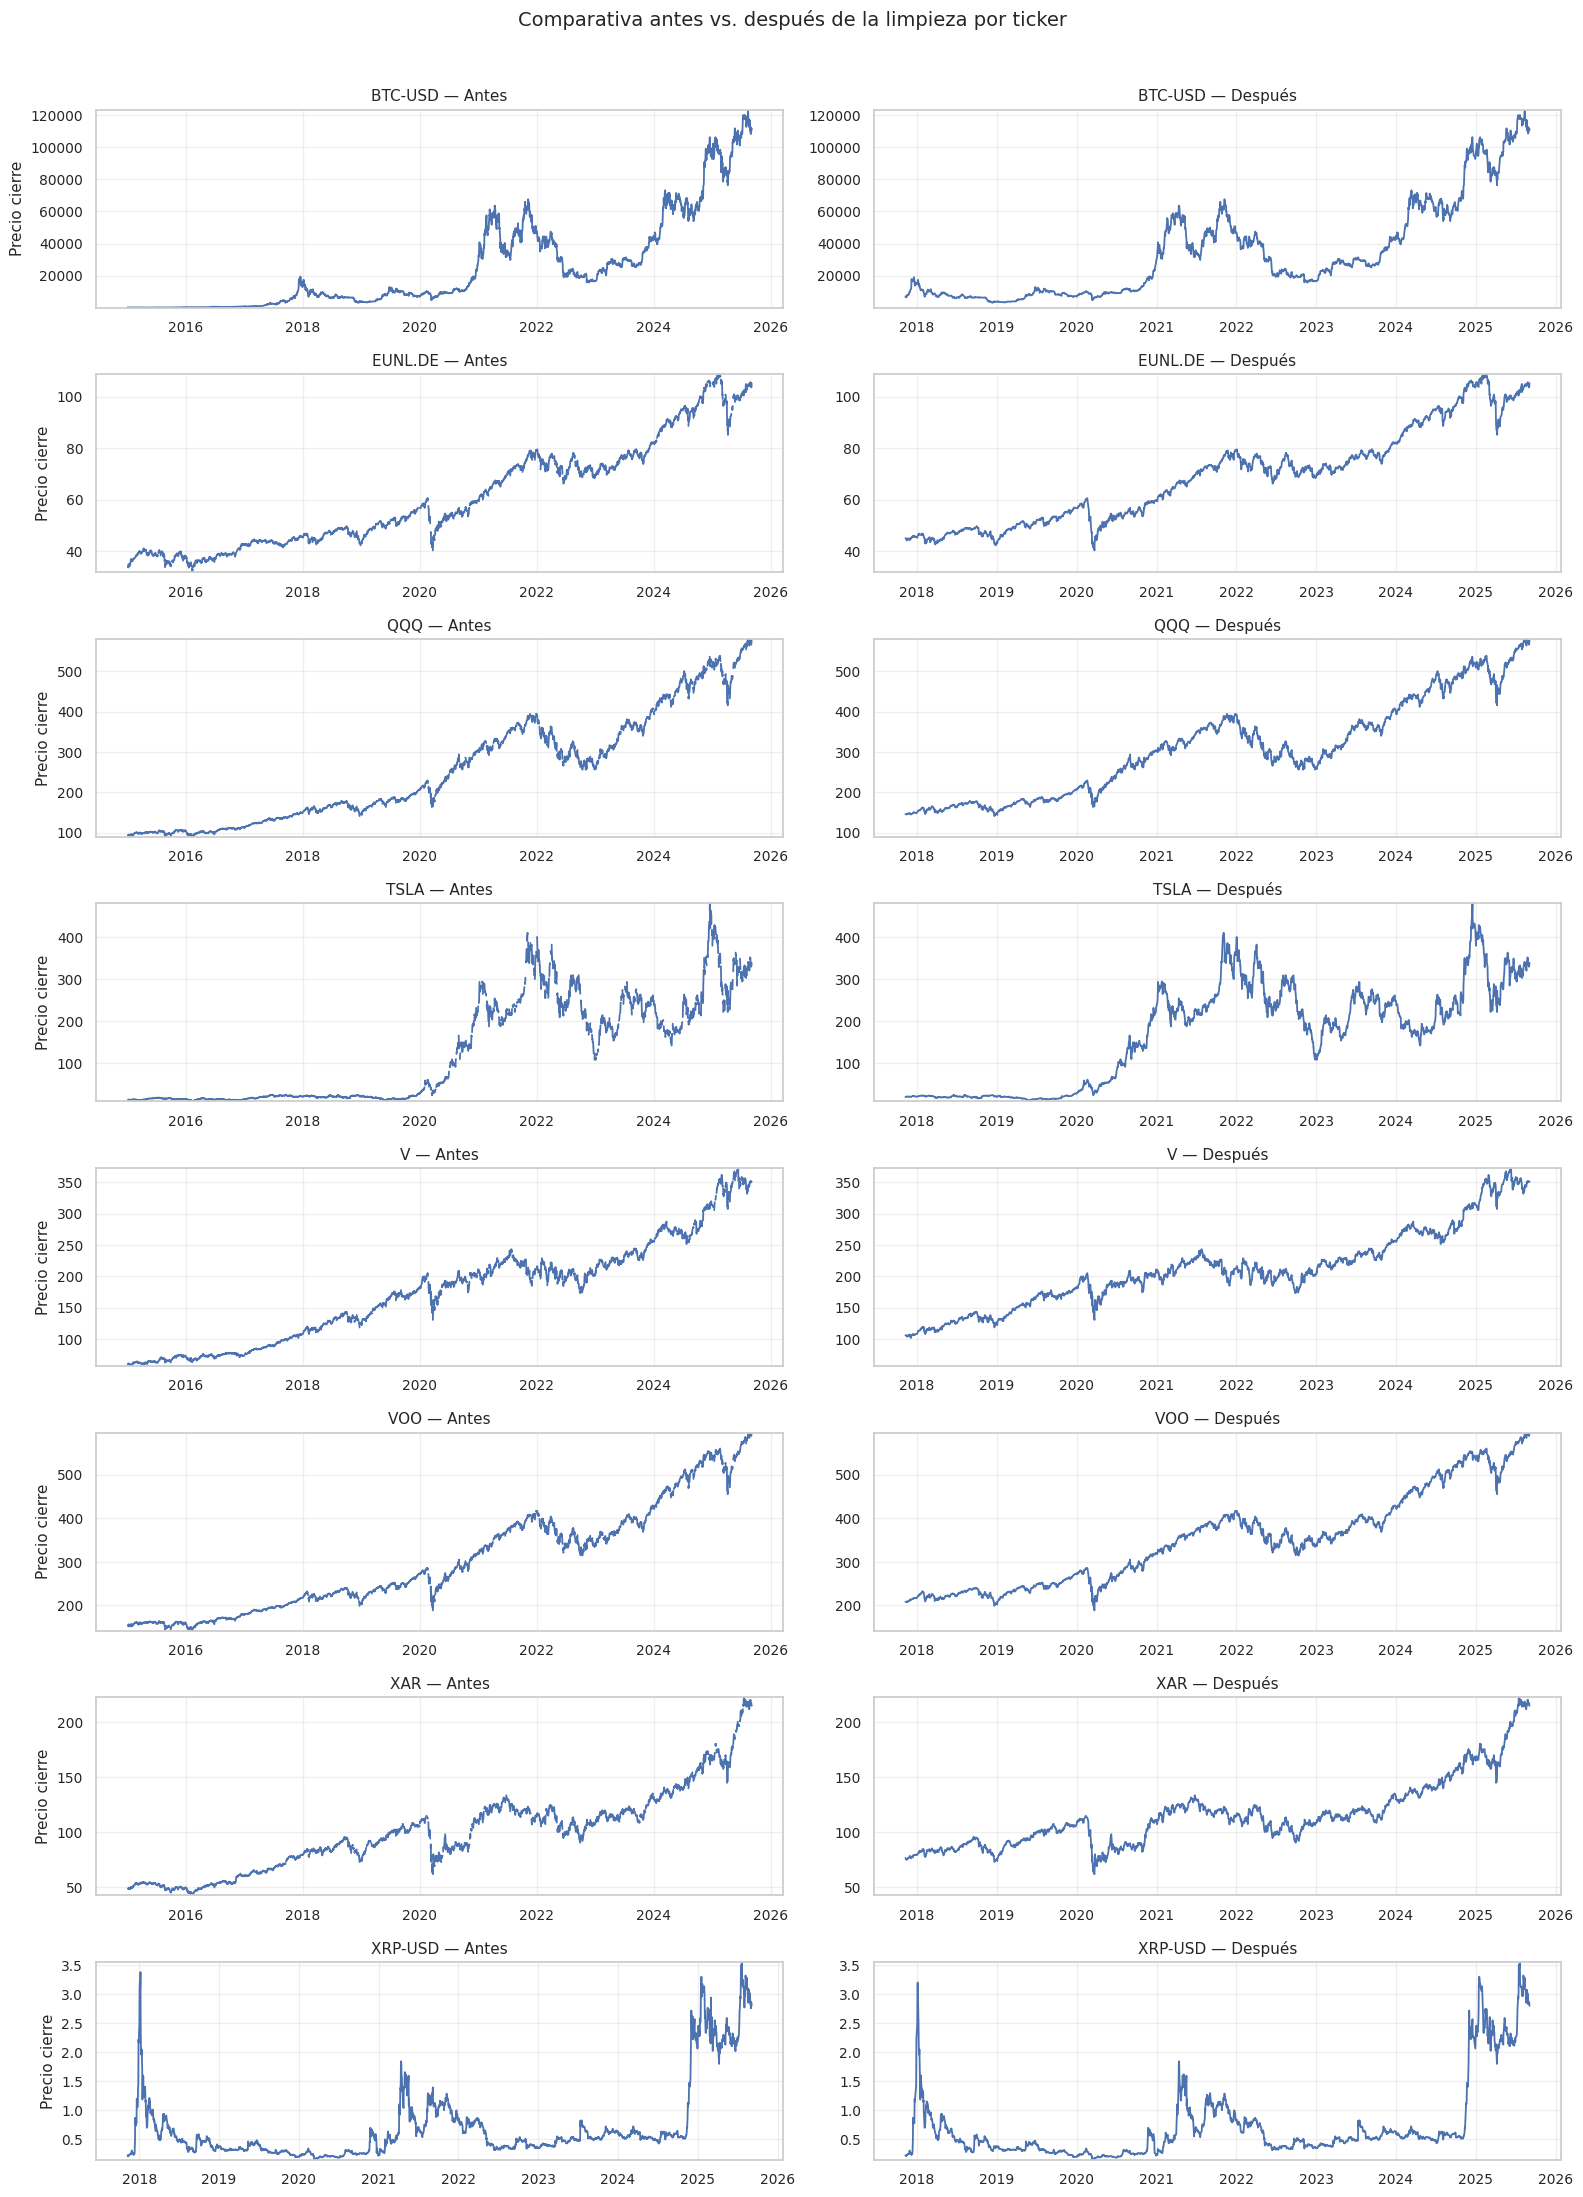

In [184]:
"""Comparativa de graficas por ticker"""
plot_before_after_timeseries(market_df, market_df_clean)

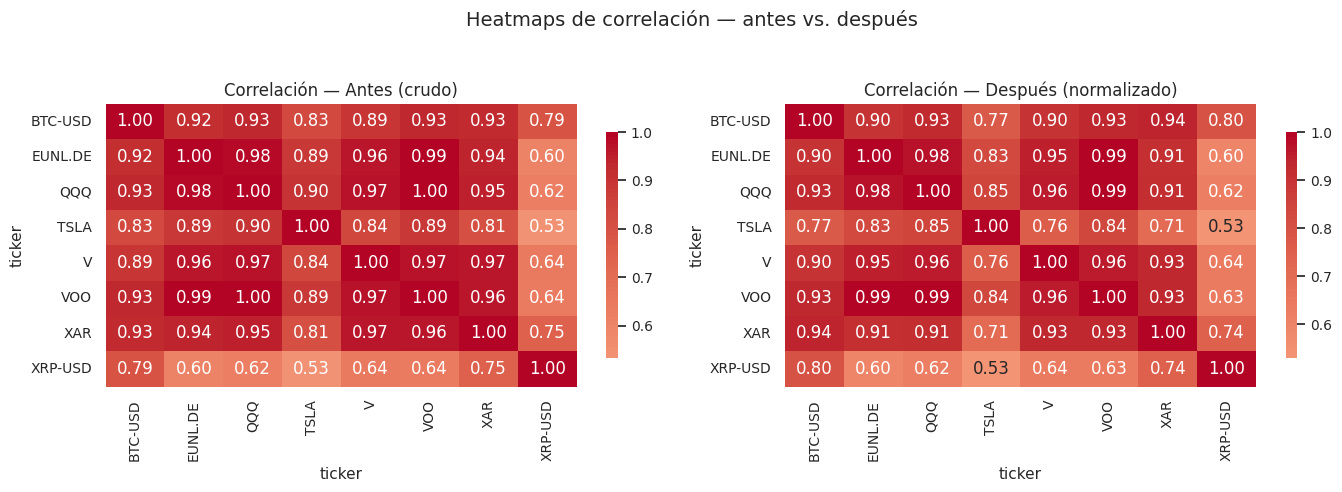

In [183]:
"""Compativas de heatmaps de correlación lado a lado"""
plot_before_after_corr(market_df, market_df_clean)